# Exploratory code to compare CT processing pipelines
    1. Dataset: ABIDE (https://riojournal.com/article/13726/) 
    2. Pipelines: ANTS, FreeSurfer, CIVET
    3. Atlas: DKT
    4. Plots: data distributoins, clusters, t-sne
    5. Analysis: statistical models (e.g. OLS, ML classifiers) 
    
## DX: 1 Autism, 2: Controls

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Paths

In [5]:
#data_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/'
data_dir = '/Users/nikhil/code/git_repos/compare-surf-tools/data/'

ants_file = 'ABIDE_ants_thickness_data.csv'
fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv'  
subject_chk_file = 'subject_check.csv'
pheno_file = 'ABIDE_Phenotype.csv'

outlier_file = '/Users/nikhil/Downloads/OutliersGroupPipe.csv'
#outlier_file = '/Users/nikhil/Downloads/nonAdjOutliersGroupPipe.csv'
study_file = data_dir + 'standardized/study_data_df.csv'

#outlier_file = '/Users/nikhil/Downloads/ageOutliersGroupPipeline_v2.csv'
fs60_file_lh = '/Users/nikhil/Downloads/aparc_lh_thickness_table.txt'
fs60_file_rh = '/Users/nikhil/Downloads/aparc_rh_thickness_table.txt'

## Read data

In [6]:
ants_data = pd.read_csv(data_dir + ants_file, header=2)
fs53_data = pd.read_csv(data_dir + fs53_file)
fs51_data = pd.read_csv(data_dir + fs51_file)
subject_ckh = pd.read_csv(data_dir + subject_chk_file)
pheno = pd.read_csv(data_dir + pheno_file)
pheno = pheno.rename(columns={'Subject_ID':'SubjID'})
outlier_data = pd.read_csv(outlier_file)
#study_data = pd.read_csv(study_file)

/Users/nikhil/anaconda/envs/3D_UNet_clone/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(300, 8)


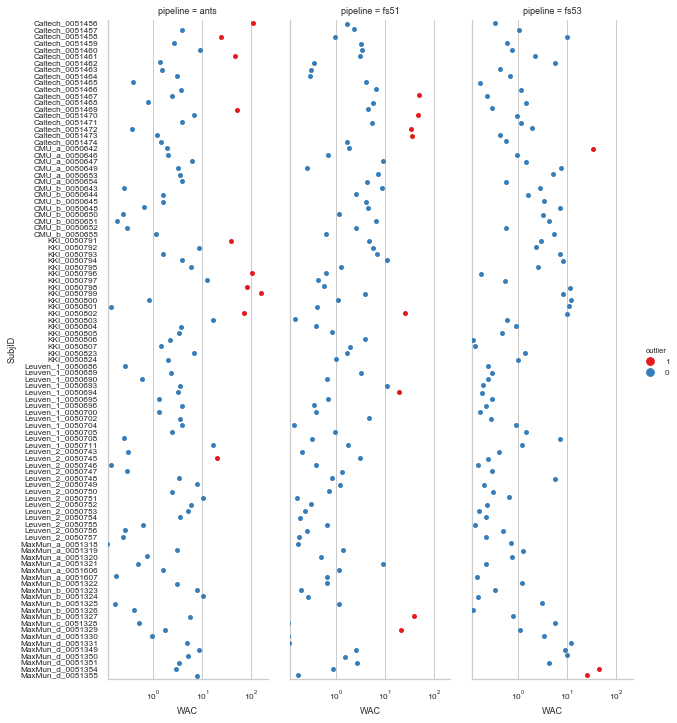

In [47]:
sample_outliers = outlier_data[outlier_data['DX_GROUP']==1]['SubjID'].values[:100]

plot_df = outlier_data[outlier_data['SubjID'].isin(sample_outliers)]
plot_df['WAC'] = plot_df['sumHim']
print(plot_df.shape)
sns.set(font_scale=0.75)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='WAC',y='SubjID',col='pipeline',kind='strip',hue='outlier',
                    data=plot_df,palette='Set1',height=10,aspect=0.3,hue_order=[1,0])
    g.set(xscale="log");


In [49]:

g.savefig('/Users/nikhil/Desktop/outlier.png', dpi=800)

In [7]:
print('dataframe shapes:')
print('pheno {}, ants {}, fs51 {}. fs53 {}'.format(pheno.shape, ants_data.shape, 
                                                   fs51_data.shape, fs53_data.shape))
print('\noutlier counts:')
pipe_outlier = {}
for pipe in set(outlier_data['pipeline']):
    p_o = outlier_data[(outlier_data['pipeline']==pipe) & (outlier_data['outlier']==1)]['SubjID'].values
    pipe_outlier[pipe] = p_o
    print('{} {}'.format(pipe, np.shape(p_o)[0]))
    
# outlier overlap
print(len(set(pipe_outlier['ants']) & set(pipe_outlier['fs51'])))
print(len(set(pipe_outlier['ants']) & set(pipe_outlier['fs53'])))
print(len(set(pipe_outlier['fs51']) & set(pipe_outlier['fs53'])))

dataframe shapes:
pheno (1112, 102), ants (1101, 99), fs51 (1112, 74). fs53 (976, 74)

outlier counts:
fs53 60
ants 46
fs51 29
1
2
2


## Create unified list of ROIs

In [8]:
# ANTS
ants_useful_cols = ['Structure Name']
ants_to_std_naming_dict = {}
ants_to_std_naming_dict['Structure Name'] = 'SubjID'
for roi in ants_data.columns:
    prefix = None
    name_split = roi.split(' ')
    if name_split[0] == 'left':
        prefix = 'L'
    if name_split[0] == 'right':
        prefix = 'R'

    if prefix is not None:
        ants_useful_cols.append(roi)
        std_name = prefix + '_' + ''.join(name_split[1:])
        ants_to_std_naming_dict[roi] = std_name

In [9]:
# FS
fs_useful_cols = ['SubjID']
fs_col_renames = {}
for roi in fs51_data.columns:
    prefix = None
    name_split = roi.split('_')
    if name_split[0] in ['L','R']:
        roi_rename = name_split[0] + '_' + name_split[1]
        fs_useful_cols.append(roi_rename)
        fs_col_renames[roi] = roi_rename
        
fs51_data = fs51_data.rename(columns=fs_col_renames)
fs53_data = fs53_data.rename(columns=fs_col_renames)

In [10]:
# standardize common naming, subjects, and columns
ants_data_std = ants_data[ants_useful_cols]
ants_data_std = ants_data_std.rename(columns=ants_to_std_naming_dict)

fs51_data_std = fs51_data[fs_useful_cols]
fs53_data_std = fs53_data[fs_useful_cols]
print('ANTS, FS 5.1, 5.3 data shapes {}, {}'.format(ants_data_std.shape, fs51_data_std.shape, fs53_data_std.shape))

# Common columns 
common_cols = list(set(ants_data_std.columns) & set(fs51_data_std.columns))
common_roi_cols = common_cols[:] #.copy()
common_roi_cols.remove('SubjID')
ants_data_std = ants_data_std[common_cols]
ants_data_std['pipeline'] = np.tile('ants',len(ants_data_std))
fs51_data_std = fs51_data_std[common_cols]
fs51_data_std['pipeline'] = np.tile('fs51',len(fs51_data_std))
fs53_data_std = fs53_data_std[common_cols]
fs53_data_std['pipeline'] = np.tile('fs53',len(fs53_data_std))

# Common subjects
common_subs = list(set(ants_data_std['SubjID'].values) & set(fs51_data_std['SubjID'].values) & set(fs53_data_std['SubjID'].values))
ants_data_std = ants_data_std[ants_data_std['SubjID'].isin(common_subs)]
fs51_data_std = fs51_data_std[fs51_data_std['SubjID'].isin(common_subs)]
fs53_data_std = fs53_data_std[fs53_data_std['SubjID'].isin(common_subs)]

print('After selecting common subjects {} and columns {}\nData shapes for ants {}, FS 5.1 {}, FS 5.3 {}'.format(len(common_subs), 
                                                                                                                len(common_cols),
                                                                                                                ants_data_std.shape,
                                                                                                                fs51_data_std.shape,
                                                                                                                fs53_data_std.shape))

ANTS, FS 5.1, 5.3 data shapes (1101, 90), (1112, 69)
After selecting common subjects 975 and columns 63
Data shapes for ants (975, 64), FS 5.1 (975, 64), FS 5.3 (975, 64)


In [11]:
# Add the outlier column for each pipeline df
ants_data_std = pd.merge(ants_data_std,outlier_data[outlier_data['pipeline']=='ants'][['SubjID','outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#ants_data_std = ants_data_std.fillna(0)
fs51_data_std = pd.merge(fs51_data_std,outlier_data[outlier_data['pipeline']=='fs51'][['SubjID','outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#fs51_data_std = fs51_data_std.fillna(0)
fs53_data_std = pd.merge(fs53_data_std,outlier_data[outlier_data['pipeline']=='fs53'][['SubjID','outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#fs53_data_std = fs53_data_std.fillna(0)
print(ants_data_std.shape,fs51_data_std.shape,fs53_data_std.shape)

((975, 67), (975, 67), (975, 67))


In [12]:
# Melt the longform df for plotting... 
master_data_df = ants_data_std.append(fs51_data_std).append(fs53_data_std)

master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline','outlier','groupSowft','DX_GROUP'], 
                              value_vars=common_roi_cols, var_name='ROI', value_name='thickness')

#master_data_df_melt[['ROI','measure']] = master_data_df_melt['ROI'].str.split('_',expand=True)[1:3]

## Plots: distributions

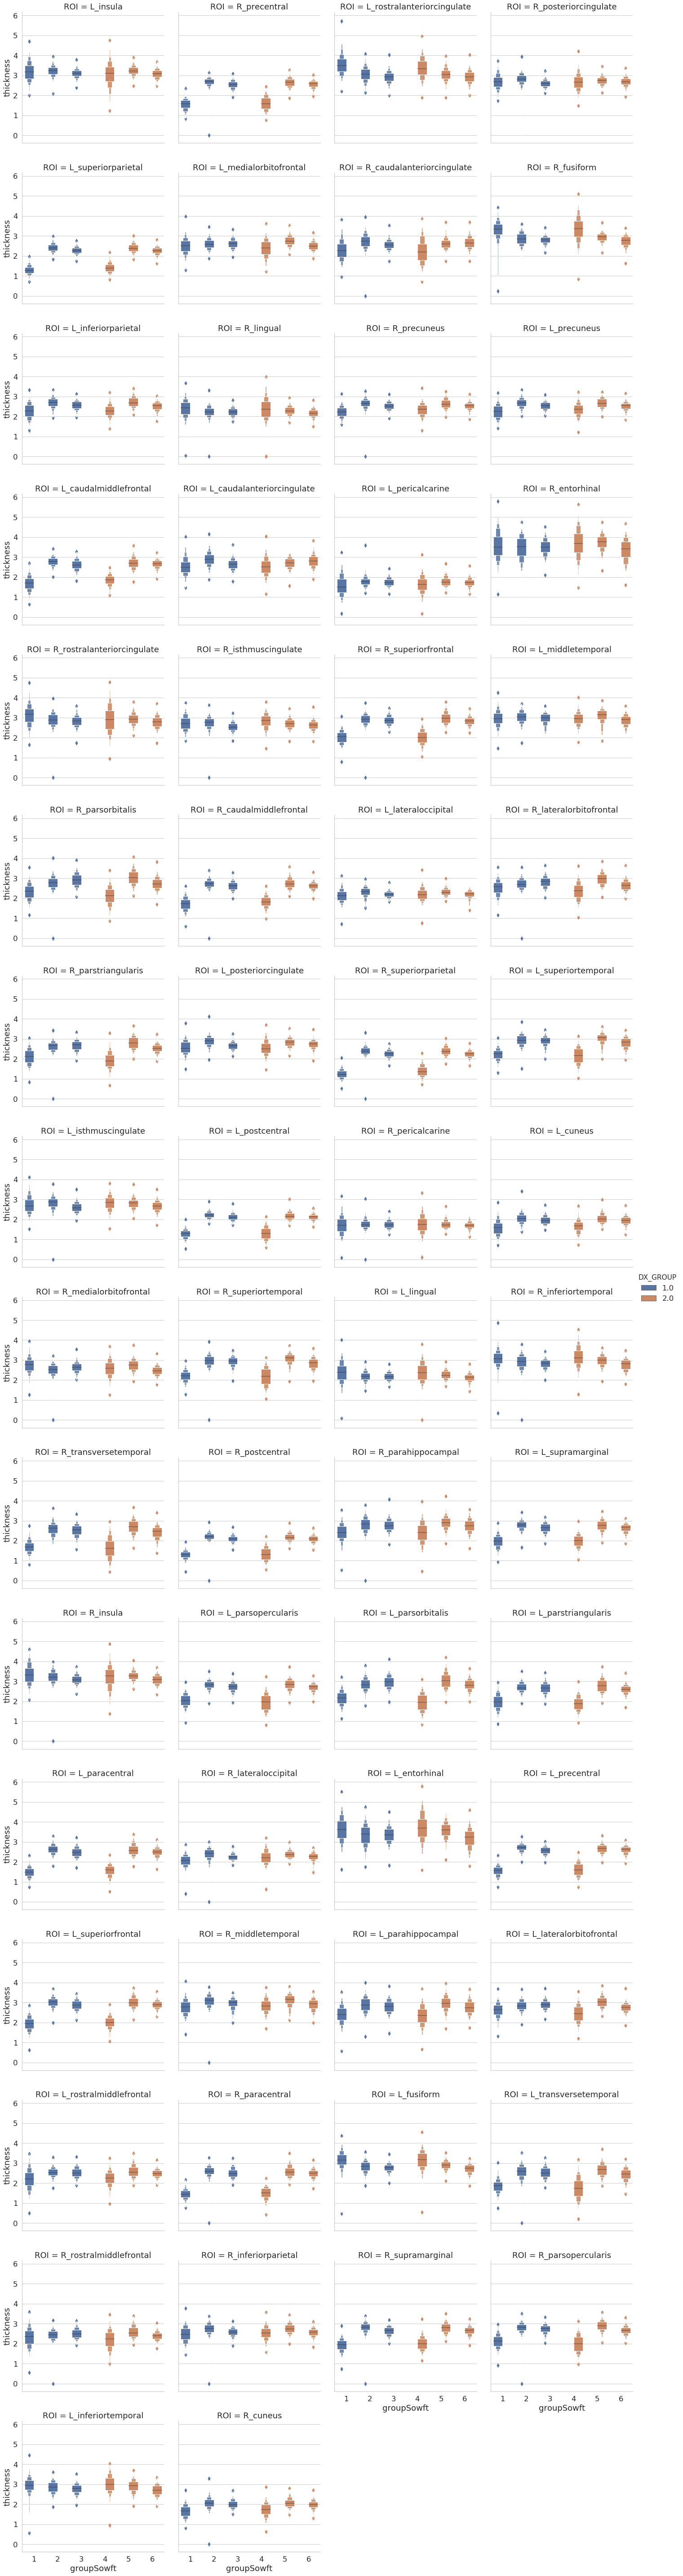

In [70]:
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='thickness', x='groupSowft', hue='DX_GROUP', kind='boxen', col='ROI', col_wrap=4, 
                    data=master_data_df_melt)


## Filter df based on outliers and concat (horizontally)

In [13]:
include_sub_tags = [0,1] # if 0 implies exclude outliers; else use [0,1]  

ants_data_std_filtered = ants_data_std[ants_data_std['outlier'].isin(include_sub_tags)]
ants_data_corr = ants_data_std_filtered[common_cols]
ants_data_corr.columns = [str(col) + '_ants' for col in ants_data_corr.columns]
ants_data_corr = ants_data_corr.rename(columns={'SubjID_ants':'SubjID'})

fs51_data_std_filtered = fs51_data_std[fs51_data_std['outlier'].isin(include_sub_tags)]
fs51_data_corr = fs51_data_std_filtered[common_cols]
fs51_data_corr.columns = [str(col) + '_fs51' for col in fs51_data_corr.columns]
fs51_data_corr = fs51_data_corr.rename(columns={'SubjID_fs51':'SubjID'})

fs53_data_std_filtered = fs53_data_std[fs53_data_std['outlier'].isin(include_sub_tags)]
fs53_data_corr = fs53_data_std_filtered[common_cols]
fs53_data_corr.columns = [str(col) + '_fs53' for col in fs53_data_corr.columns]
fs53_data_corr = fs53_data_corr.rename(columns={'SubjID_fs53':'SubjID'})

concat_df = ants_data_corr.merge(fs51_data_corr, on='SubjID').merge(fs53_data_corr, on='SubjID')
print('shape after concat {}'.format(concat_df.shape))

shape after concat (975, 187)


In [ ]:
#Before 
avg corr:
ants-fs51 0.427, ants-fs53 0.474, fs51-fs53 0.875
stdev corr:
ants-fs51 0.117, ants-fs53 0.118, fs51-fs53 0.036

# After
avg corr:
ants-fs51 0.427, ants-fs53 0.473, fs51-fs53 0.870
stdev corr:
ants-fs51 0.118, ants-fs53 0.120, fs51-fs53 0.038


## Plots: correlations

avg corr:
ants-fs51 0.427, ants-fs53 0.474, fs51-fs53 0.875
stdev corr:
ants-fs51 0.117, ants-fs53 0.118, fs51-fs53 0.036


/Users/nikhil/anaconda/envs/3D_UNet_clone/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


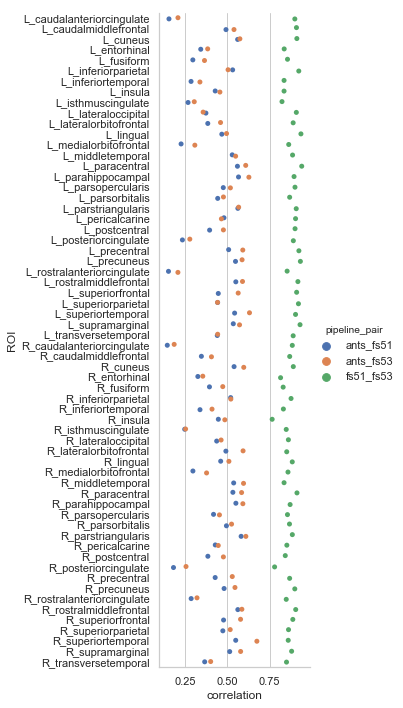

In [14]:
corr = concat_df.corr()

# avg cross-correlations using diangonals (corrwith from pandas doesn't work)
ants_fs51 = corr.values[:62,62:124].diagonal()
ants_fs53 = corr.values[:62,124:].diagonal()
fs51_fs53 = corr.values[62:124,124:].diagonal()

print('avg corr:\nants-fs51 {:4.3f}, ants-fs53 {:4.3f}, fs51-fs53 {:4.3f}'.format(np.mean(ants_fs51),
                                                                   np.mean(ants_fs53),
                                                                   np.mean(fs51_fs53)))

print('stdev corr:\nants-fs51 {:4.3f}, ants-fs53 {:4.3f}, fs51-fs53 {:4.3f}'.format(np.std(ants_fs51),
                                                                   np.std(ants_fs53),
                                                                   np.std(fs51_fs53)))


# plot all pair-wise corrs (not really needed for seeing inter-pipeline comparisons)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 20, n=7)

# Draw the heatmap with the mask and correct aspect ratio
# plt.figure(figsize=(20,20))
# sns.set(font_scale=1)
# sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5,center=0)

# Plot roi-wise correlation
df_corr_pairs = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs51_df = pd.DataFrame(columns=['correlation','ROI','pipeline_pair'])
ants_fs51_df['correlation'] =  ants_fs51
ants_fs51_df['ROI'] = common_roi_cols
ants_fs51_df['pipeline_pair'] = np.tile('ants_fs51',62)

ants_fs53_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
ants_fs53_df['correlation'] =  ants_fs53
ants_fs53_df['ROI'] = common_roi_cols
ants_fs53_df['pipeline_pair'] = np.tile('ants_fs53',62)

fs51_fs53_df = pd.DataFrame(columns=['corr','ROI','pipeline_pair'])
fs51_fs53_df['correlation'] =  fs51_fs53
fs51_fs53_df['ROI'] = common_roi_cols
fs51_fs53_df['pipeline_pair'] = np.tile('fs51_fs53',62)


df_corr_pairs = df_corr_pairs.append(ants_fs51_df).append(ants_fs53_df).append(fs51_fs53_df)

roi_order = sorted(list(df_corr_pairs['ROI'].unique()))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,
                data=df_corr_pairs,aspect=.5,height=10,kind='strip')
    

In [16]:
g.savefig('/Users/nikhil/Desktop/roi_compare.png', dpi=400)

## Plots: clusters

Text(0.5, 0.98, 'fs5.3')

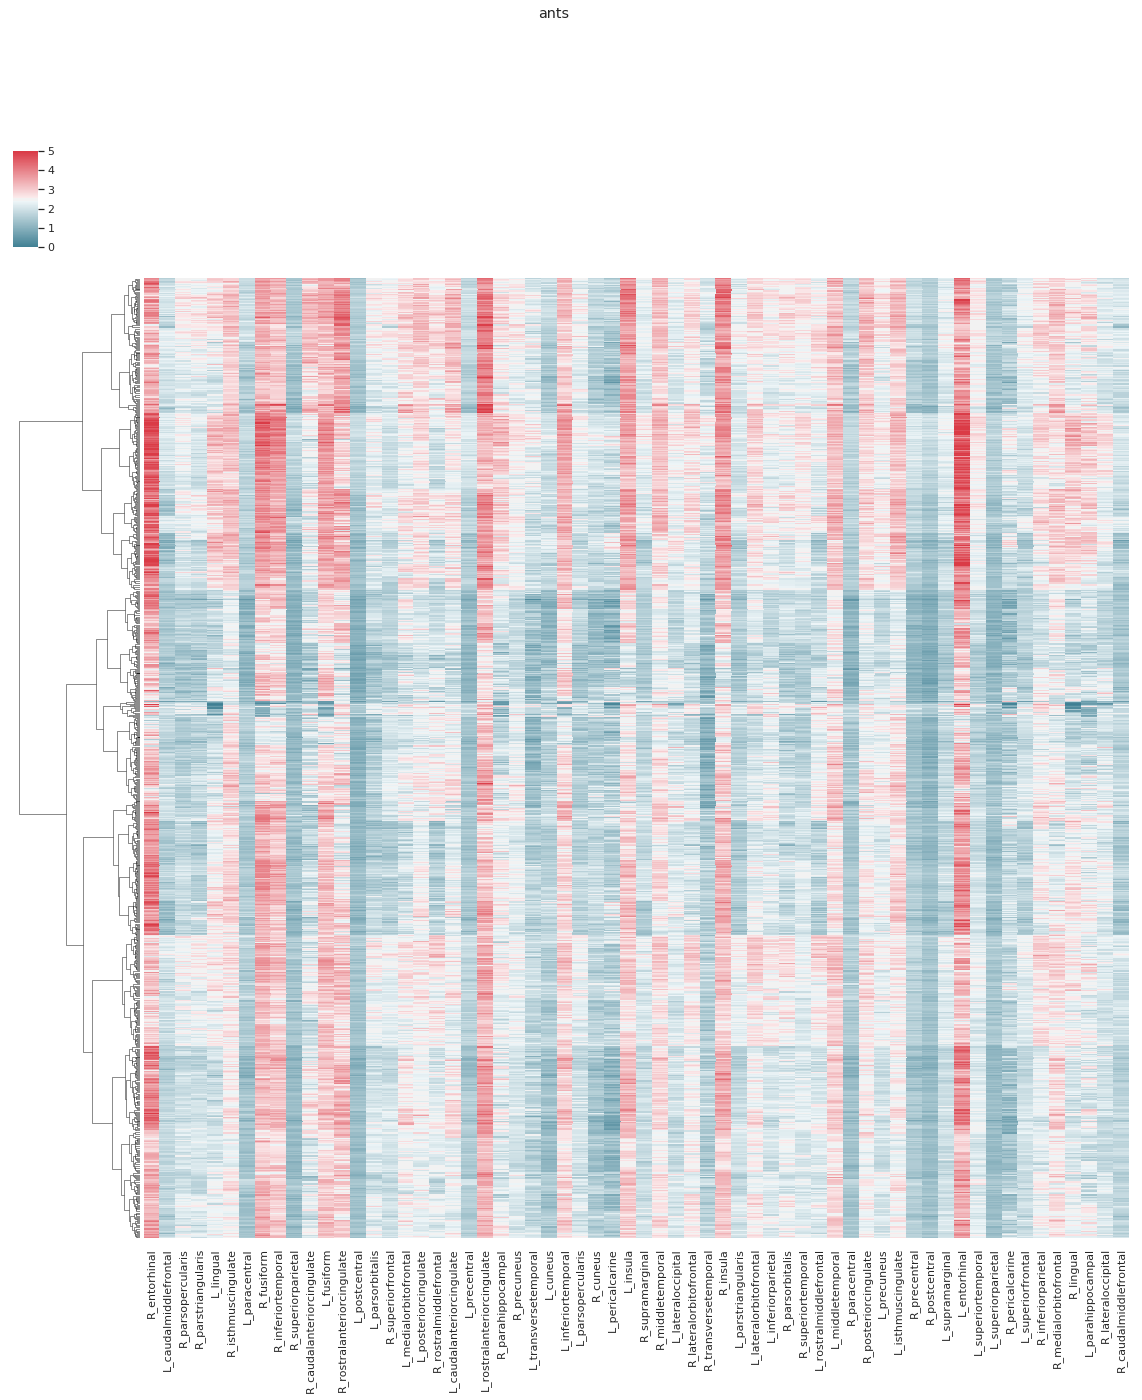

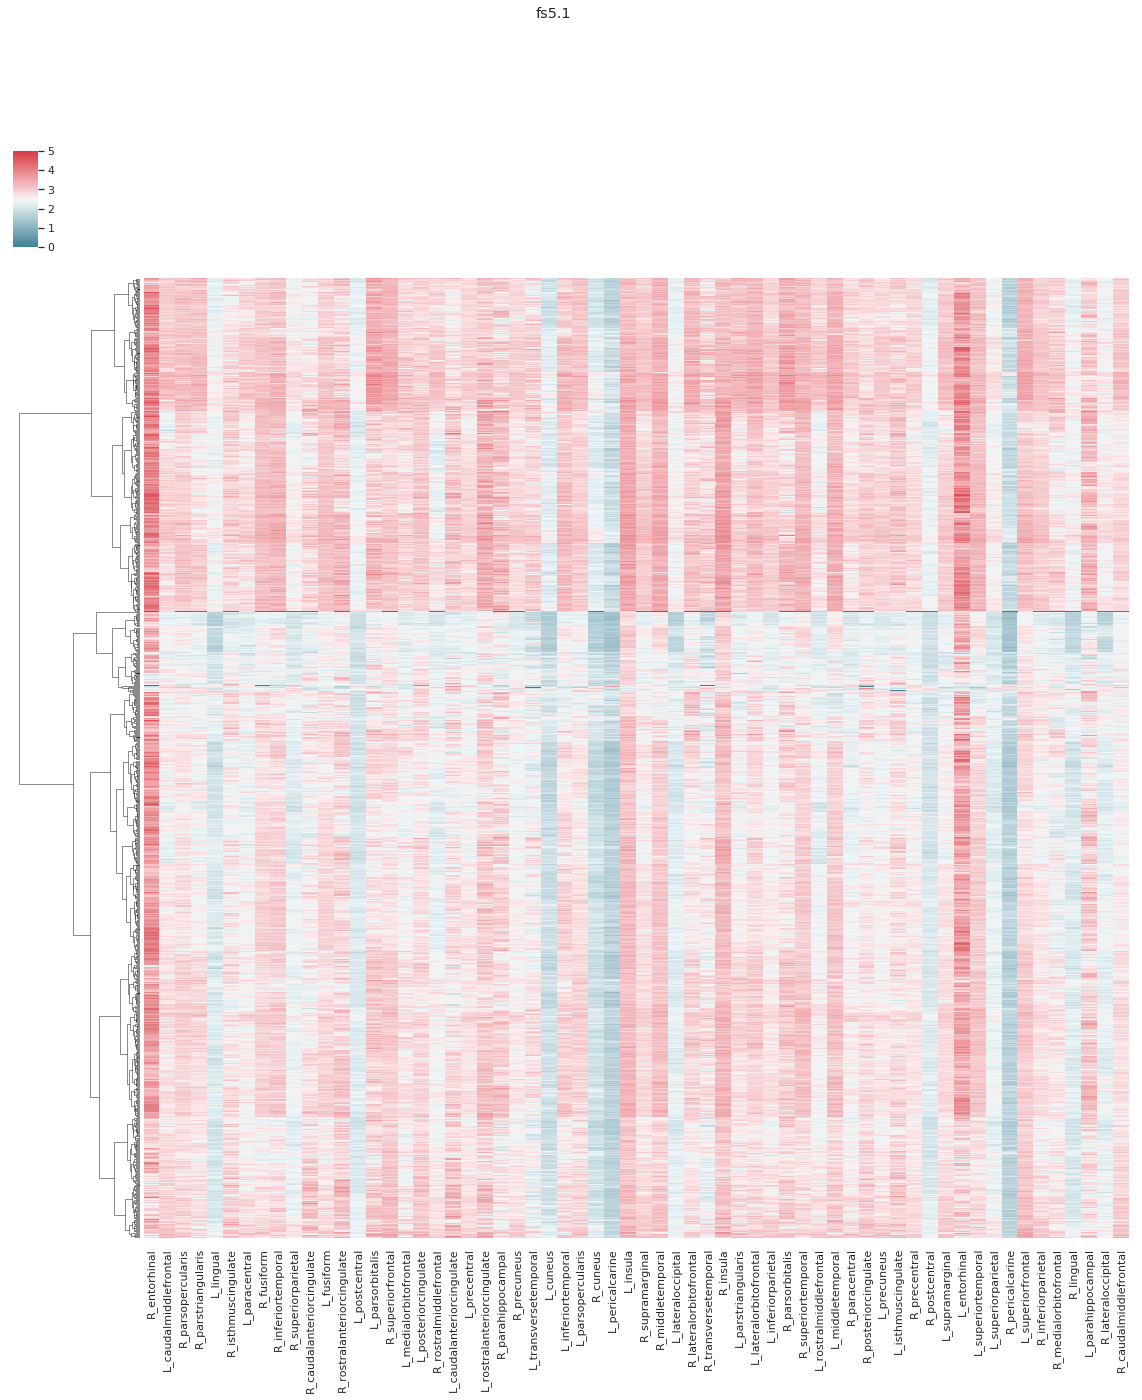

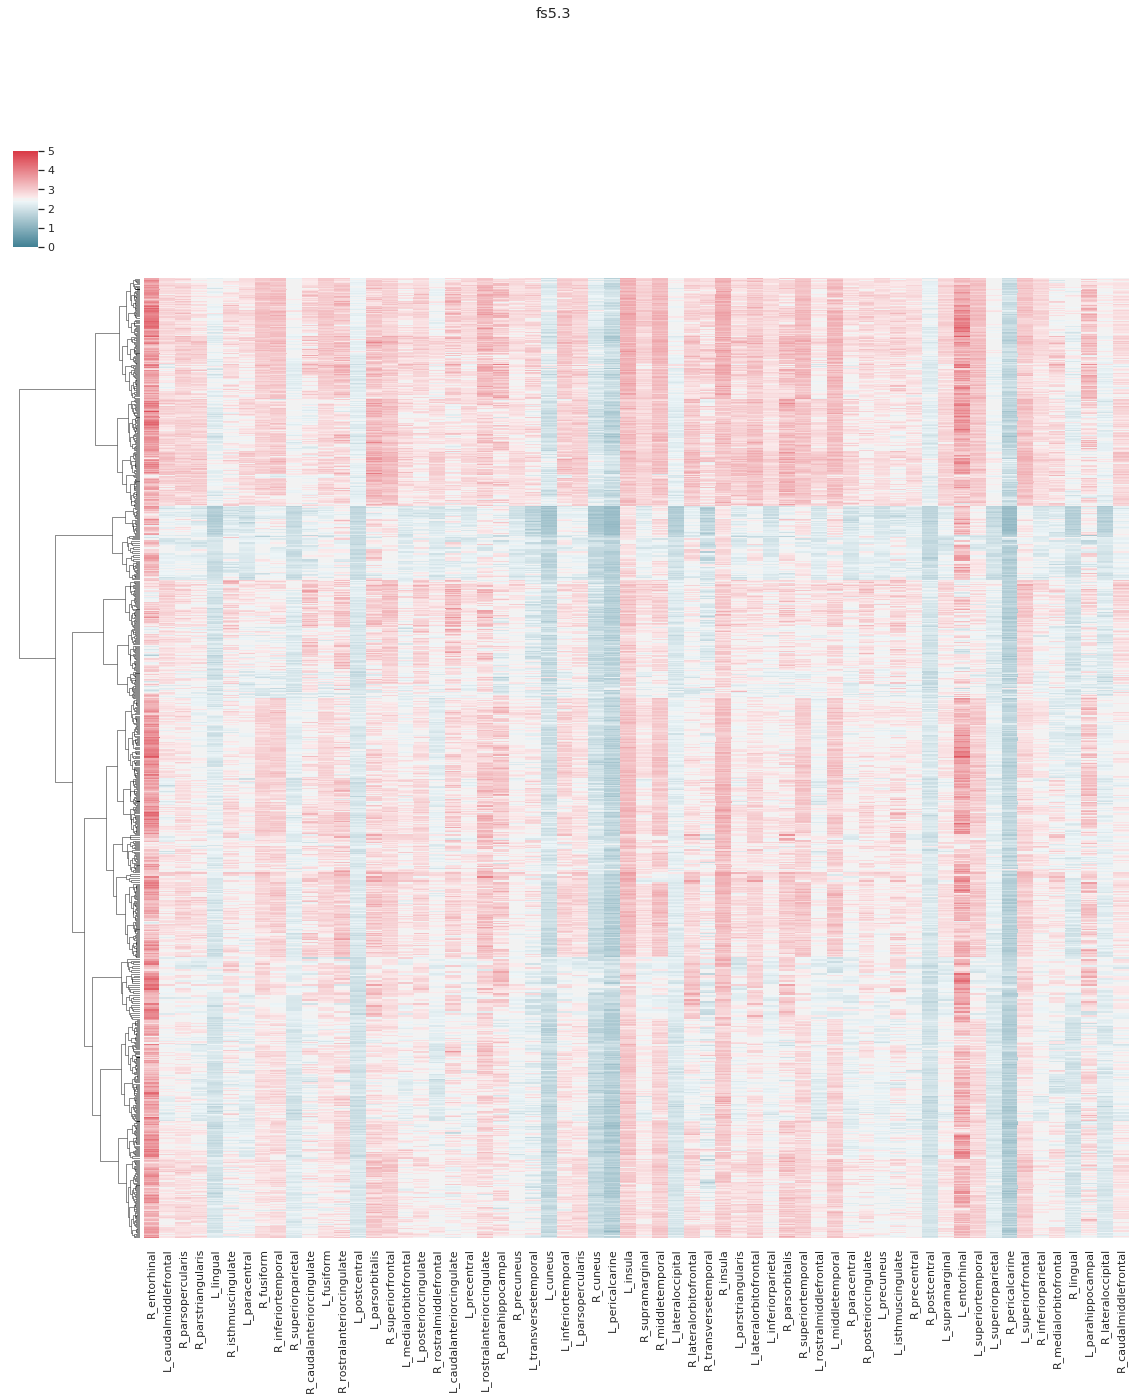

In [62]:
sns.set(style="white")
sns.set(font_scale=1)

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

g1 = sns.clustermap(ants_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g1.fig.suptitle('ants')

g2 = sns.clustermap(fs51_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g2.fig.suptitle('fs5.1')

g3 = sns.clustermap(fs53_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g3.fig.suptitle('fs5.3')

In [63]:
# cluster memberships
# Very basic - assumes same order of cluster-class for each pipeline 
# TODO - pairwise memberships

import scipy.cluster.hierarchy as sch
import collections

def get_cluster_membership(_df,g,n_clusters):
    member_df = _df[['SubjID','pipeline']].copy()
    Z = g.dendrogram_row.linkage
    T = sch.fcluster(Z, n_clusters, 'maxclust')
    member_count = collections.Counter(T)
    print('Pipeline {}, cluster sizes {}'.format(member_df['pipeline'].values[0], member_count))
    member_df['membership'] = T
    return member_df

def get_cluster_overlap(df1,df2):
    #assert len(df1) == len(df2)
    concat_df = pd.merge(df1,df2,on='SubjID',how='inner')
    overlap = np.sum(concat_df['membership_x'].values  == concat_df['membership_y'].values)/len(concat_df)
    return overlap                    

In [64]:
n_cluster = 2
print('Sanity check: largest and smallest clusters should have same cluster_ids across pipelines\n')
      
cluster_df = pd.DataFrame()
C1_member = get_cluster_membership(ants_data_std_filtered, g1, n_cluster)
C2_member = get_cluster_membership(fs51_data_std_filtered, g2, n_cluster)
C3_member = get_cluster_membership(fs53_data_std_filtered, g3, n_cluster)

C1_C2_overlap = get_cluster_overlap(C1_member,C2_member)
C1_C3_overlap = get_cluster_overlap(C1_member,C3_member)
C2_C3_overlap = get_cluster_overlap(C2_member,C3_member)

print('\ncluster membership overlap: C1_C2 {:3.2f}, C1_C3 {:3.2f}, C2_C3 {:3.2f}'.format(C1_C2_overlap,C1_C3_overlap,C2_C3_overlap))

Sanity check: largest and smallest clusters should have same cluster_ids across pipelines

Pipeline ants, cluster sizes Counter({2: 658, 1: 317})
Pipeline fs51, cluster sizes Counter({2: 636, 1: 339})
Pipeline fs53, cluster sizes Counter({2: 743, 1: 232})

cluster membership overlap: C1_C2 0.60, C1_C3 0.63, C2_C3 0.85


## Plot: t-SNE

In [17]:
from sklearn.manifold import TSNE
include_sub_tags = [0,1]

master_data_df_filtered = master_data_df[(master_data_df['outlier'].isin(include_sub_tags))]
X = master_data_df_filtered[common_roi_cols].values
print(master_data_df_filtered.shape)

(2925, 67)


In [18]:
X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(2925, 2)

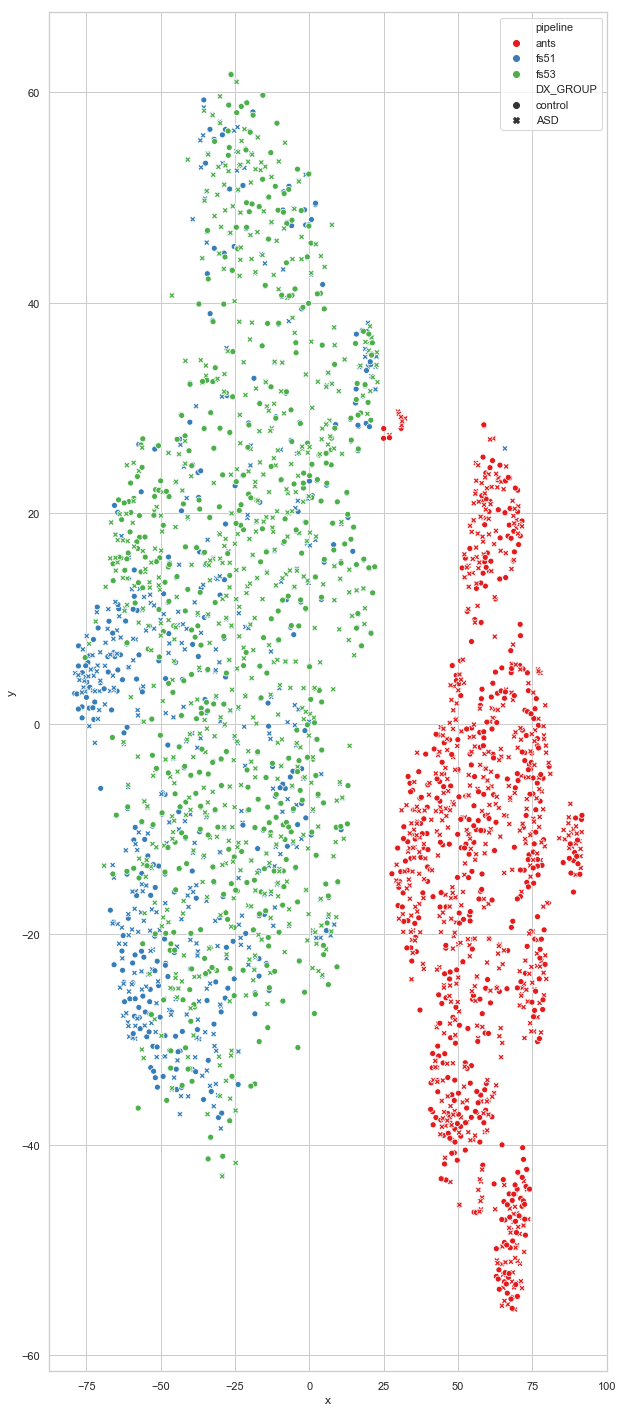

In [28]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df['groupSowft'] = master_data_df_filtered['groupSowft'].values
embed_df['pipeline'] = master_data_df_filtered['pipeline'].values
embed_df['DX_GROUP'] = master_data_df_filtered['DX_GROUP'].values
embed_df['outlier'] = master_data_df_filtered['outlier'].values

embed_df['groupSowft'] = embed_df['groupSowft'].replace({1:'ants+control', 2:'fs5.1+control', 3:'fs5.3+control',
                                                         4:'ants+ASD', 5:'fs5.1+ASD', 6:'fs5.3+ASD'})

#embed_df['Outlier'] = embed_df['Outlier'].replace({1:'outlier', 0:'normal'})
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({1:'control', 2:'ASD'})

plt.figure(figsize=(10,25))
sns.set(font_scale=1) 
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue='pipeline',style='DX_GROUP',
                    data=embed_df,palette="Set1")
    g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

## ML classifier - sanity check

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm

pipe_pairs = {'ants' : ['ants'],
              'fs5.1' : ['fs51'],
              'fs5.3' : ['fs53']}
# pipe_pairs = {'ants vs. fs5.1' : ['ants','fs51'],
#               'ants vs. fs5.3' : ['ants','fs53'],
#               'fs5.1 vs. fs5.3' : ['fs51','fs53']}

n_folds = 100
all_scores = pd.DataFrame(columns=['pipeline','Acc'])
scores = pd.DataFrame(columns=['pipeline','Acc'])
for i, pair in enumerate(pipe_pairs.keys()):
    ml_df = master_data_df_filtered[master_data_df_filtered['pipeline'].isin(pipe_pairs[pair])]
    X = ml_df[common_roi_cols].values
    y = pd.get_dummies(ml_df['DX_GROUP']).values[:,0]

    clf = svm.SVC(kernel='linear')
    acc = cross_val_score(clf, X, y, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10))
    scores['pipeline'] = np.tile(pair,len(acc))
    scores['Acc'] = acc
    all_scores = all_scores.append(scores)

    print('DX {}, discriminative acc mean:{:4.3f}, stdev:{:4.3f}'.format(pair,np.mean(acc),np.std(acc)))

DX fs5.1, discriminative acc mean:0.530, stdev:0.052
DX fs5.3, discriminative acc mean:0.550, stdev:0.052
DX ants, discriminative acc mean:0.561, stdev:0.042


In [35]:
DX ants, discriminative acc mean:0.563, stdev:0.046
DX fs5.3, discriminative acc mean:0.546, stdev:0.050
DX fs5.1, discriminative acc mean:0.533, stdev:0.043

SyntaxError: invalid syntax (<ipython-input-35-d259b57c09e3>, line 1)

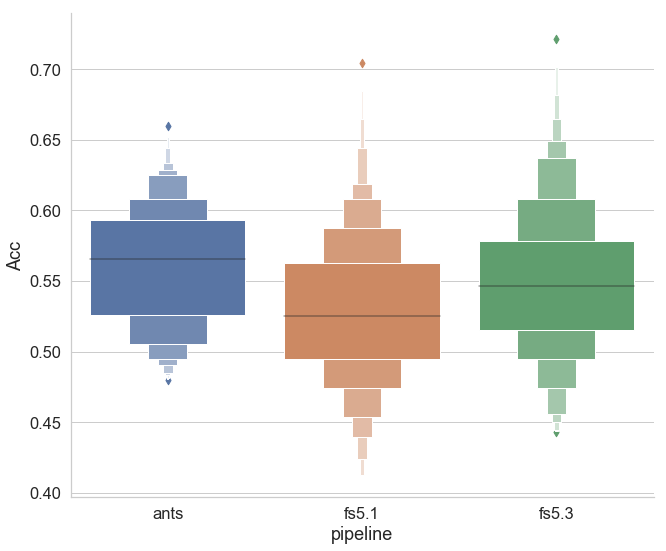

In [31]:
x_order = ['ants','fs5.1','fs5.3']
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='Acc',x='pipeline',data=all_scores,kind='boxen',order=x_order,aspect=1.2,height=8)

In [33]:
g.savefig('/Users/nikhil/Desktop/ml.png', dpi=300)

# Sample Research Question
* Predict age from cortical thickness

In [43]:
ml_df['DX_GROUP'].value_counts()

2    523
1    452
Name: DX_GROUP, dtype: int64

In [59]:
import statsmodels.api as sm

useful_demograph = pheno[['SubjID','SEX','AGE_AT_SCAN','FIQ','BMI']]
study_data_df = pd.merge(master_data_df_filtered, useful_demograph, how='left', on='SubjID')
print(study_data_df.shape)

(2925, 71)


## OLS: age ~ cortical_thickness [+ sex + Dx] 

In [114]:
# Lasso based multiple regression with all ROIs

dependent_var = 'AGE_AT_SCAN' #(either AGE_AT_SCAN of DX_GROUP)
results_df = pd.DataFrame(columns=list(range(n_pc)) + ['pipeline','metric'])
p = 0
n_pc = len(common_roi_cols)
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    if dependent_var =='DX_GROUP':
        y = pd.get_dummies(analysis_df['DX_GROUP']).values[:,0]
    else:
        y = analysis_df[dependent_var].values
    
    # OLS or Logit
    t_val_list = []
    p_val_list = []
    R2_adj_list = []
    ci_val_list = []
    
    #lasso
    X_roi = analysis_df[common_roi_cols]
    
    if dependent_var =='DX_GROUP':
        X = np.hstack((X_roi, analysis_df[['SEX','AGE_AT_SCAN']].values))
        print(X.shape)
        model = sm.Logit(y,X)
        #results = model.fit()
    else:
        X = np.hstack((X_roi, analysis_df[['SEX','DX_GROUP']].values))
        print(X.shape)
        #X = sm.add_constant(X)
        model = sm.OLS(y,X)
        results = model.fit_regularized()
        
    
#     t_val = results.tvalues[:n_pc] # just for ROI
#     p_val = results.pvalues[:n_pc] # just for ROI
#     ci_val = results.conf_int()[n_pc]
#     t_val_list.append(t_val)
#     p_val_list.append(p_val)
#     ci_val_list.append(ci_val)

#     if dependent_var =='AGE_AT_SCAN':
#         r2_adj_val = results.rsquared_adj
#         R2_adj_list.append(r2_adj_val)

#     results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
#     p+=1
#     results_df.loc[p] = list(p_val_list[0]) + [pipe,'p_val']
#     results_df.loc[p] = list(conf_int_val_list) + [pipe,'p_val']
#     p+=1

#     if dependent_var =='AGE_AT_SCAN':
#         results_df.loc[p] = list(R2_adj_list) + [pipe,'R2_adj']
#         p+=1

(929, 64)
(915, 64)
(946, 64)


In [113]:
results.params

array([ 3.41636774,  3.07734473, -0.16197665, -0.77535237, -1.13737303,
       -0.13178115, -0.13285793,  1.36285852, -3.20807914,  0.64223363,
       -0.96158882,  1.83996995,  0.34020105,  0.50787721, -0.90664593,
       -0.20980202,  1.40391513, -0.07450878,  0.36525211, -2.84799675,
       -0.5152971 ,  1.07820498,  1.90499875, -4.28711809,  1.68176591,
        1.03219284, -0.62812525, -2.52295019,  2.64255792, -1.04286669,
       -2.1430551 , -1.12499331,  1.47447575,  0.22557041, -1.90634909,
        3.07875345,  0.5603517 ,  0.28109888, -1.21983978, -0.2983133 ,
        0.34369344, -0.35277019,  0.91678033, -0.68351718,  0.74291485,
       -0.31832567, -2.04664275,  1.4241274 ,  0.191755  , -0.95427988,
       -1.43550318,  0.69770745, -1.69559651,  2.3746679 , -1.1383223 ,
        1.27176333, -0.47064819, -0.014898  ,  0.4703623 , -0.88935111,
       -0.25303873,  0.96252621,  2.06531515,  1.30242451])

In [106]:
# PCA based multiple regression with all ROIs
from sklearn.decomposition import PCA

dependent_var = 'AGE_AT_SCAN' #(either AGE_AT_SCAN of DX_GROUP)
results_df = pd.DataFrame(columns=list(range(n_pc)) + ['pipeline','metric'])
p = 0
n_pc = 10
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    if dependent_var =='DX_GROUP':
        y = pd.get_dummies(analysis_df['DX_GROUP']).values[:,0]
    else:
        y = analysis_df[dependent_var].values
    
    # OLS or Logit
    t_val_list = []
    p_val_list = []
    R2_adj_list = []
    ci_val_list = []
    
    #pca
    X_roi = analysis_df[common_roi_cols]
    pca = PCA(n_components=n_pc)
    pca.fit(X_roi)
    print(pipe)
    print(pca.explained_variance_ratio_)
    X_pca = pca.transform(X_roi)
    
    if dependent_var =='DX_GROUP':
        X = np.hstack((X_pca, analysis_df[['SEX','AGE_AT_SCAN']].values))
        print(X.shape)
        model = sm.Logit(y,X)
    else:
        X = np.hstack((X_pca, analysis_df[['SEX','DX_GROUP']].values))
        print(X.shape)
        #X = sm.add_constant(X)
        model = sm.OLS(y,X)
        
    results = model.fit()
    t_val = results.tvalues[:n_pc] # just for ROI
    p_val = results.pvalues[:n_pc] # just for ROI
    ci_val = results.conf_int()[n_pc]
    t_val_list.append(t_val)
    p_val_list.append(p_val)
    ci_val_list.append(ci_val)

    if dependent_var =='AGE_AT_SCAN':
        r2_adj_val = results.rsquared_adj
        R2_adj_list.append(r2_adj_val)

#     results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
#     p+=1
    results_df.loc[p] = list(p_val_list[0]) + [pipe,'p_val']
#     results_df.loc[p] = list(conf_int_val_list) + [pipe,'p_val']
    p+=1

#     if dependent_var =='AGE_AT_SCAN':
#         results_df.loc[p] = list(R2_adj_list) + [pipe,'R2_adj']
#         p+=1

ants
[0.38799686 0.14946704 0.08306207 0.05664352 0.0461757  0.03326785
 0.0260681  0.01966363 0.01694107 0.01568946]
(929, 12)
fs53
[0.39386342 0.11489463 0.07838102 0.04870244 0.04332052 0.03168397
 0.02668937 0.0190355  0.01748631 0.0154556 ]
(915, 12)
fs51
[0.45474285 0.09913386 0.06722466 0.04430357 0.03830347 0.02860317
 0.02327651 0.0218441  0.0157527  0.01482805]
(946, 12)


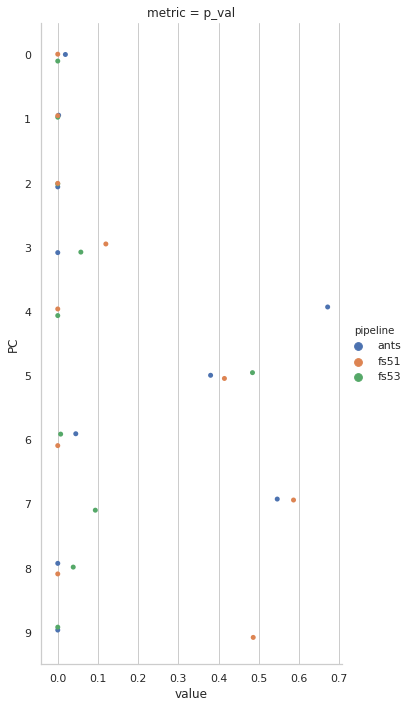

In [104]:
results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=list(range(n_pc)),
                             var_name='PC', value_name='value')

hue_order = ['ants','fs51','fs53']
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='PC', hue='pipeline', col='metric', data=results_df_melt,
                    orient='h',kind='strip',aspect=0.5,height=10,sharex=False,hue_order=hue_order)

In [70]:
# For proof-of-concept, currently implemented as multiple regression instead of mass-univariate

dependent_var = 'DX_GROUP' #(either AGE_AT_SCAN of DX_GROUP)
results_df = pd.DataFrame(columns=common_roi_cols + ['pipeline','metric'])
p = 0
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    if dependent_var =='DX_GROUP':
        y = pd.get_dummies(analysis_df['DX_GROUP']).values[:,0]
    else:
        y = analysis_df[dependent_var].values
    
    # OLS or Logit
    t_val_list = []
    p_val_list = []
    R2_adj_list = []
    ci_val_list = []
    
    for roi in common_roi_cols:
        if dependent_var =='DX_GROUP':
            X = analysis_df[[roi,'SEX','AGE_AT_SCAN']].values
            model = sm.Logit(y,X)
        else:
            X = analysis_df[[roi,'SEX','DX_GROUP']].values
            #X = sm.add_constant(X)
            model = sm.OLS(y,X)
        
        results = model.fit()
        t_val = results.tvalues[0] # just for ROI
        p_val = results.pvalues[0] # just for ROI
        ci_val = results.conf_int()[0]
        t_val_list.append(t_val)
        p_val_list.append(p_val)
        ci_val_list.append(ci_val)
        
        if dependent_var =='AGE_AT_SCAN':
            r2_adj_val = results.rsquared_adj
            R2_adj_list.append(r2_adj_val)
        
#     results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
#     p+=1
    results_df.loc[p] = list(p_val_list) + [pipe,'p_val']
    p+=1

#     if dependent_var =='AGE_AT_SCAN':
#         results_df.loc[p] = list(R2_adj_list) + [pipe,'R2_adj']
#         p+=1

Optimization terminated successfully.
         Current function value: 22.429337
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.313031
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.069072
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.305504
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.638475
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.930531
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.378134
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.984847
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.470823
         Iterations 4
Optimization terminated successfully.
         Current function value: 22

Optimization terminated successfully.
         Current function value: 22.762082
         Iterations 4
Optimization terminated successfully.
         Current function value: 23.587978
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.500723
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.816440
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.607010
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.395246
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.319519
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.454373
         Iterations 4
Optimization terminated successfully.
         Current function value: 22.445548
         Iterations 4
Optimization terminated successfully.
         Current function value: 22

In [71]:
results.summary()

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  975
Model:                          Logit   Df Residuals:                      972
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Dec 2018   Pseudo R-squ.:                     inf
Time:                        20:08:23   Log-Likelihood:                -22064.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1103      0.085      1.291      0.197      -0.057       0.278
x2            -0.4663      0.174     -2.676      0.007      -0.808      -0.125
x3             0.0051      0.007      0.707      0.480      -0.009       0.019
==============================================================================
"""

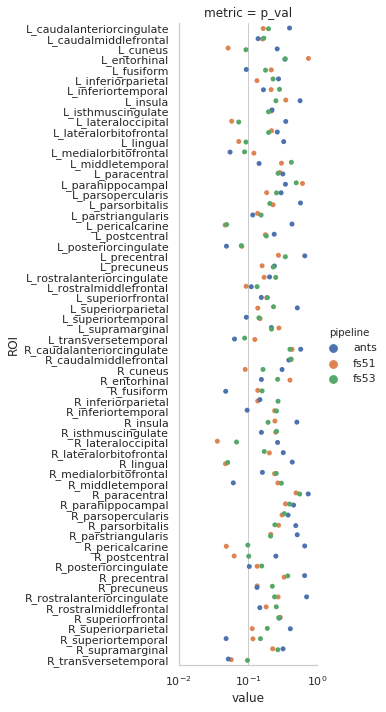

In [75]:
#Plot model results per pipeline

results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=common_roi_cols,
                             var_name='ROI', value_name='value')

hue_order = ['ants','fs51','fs53']
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='ROI', hue='pipeline', col='metric', data=results_df_melt,order=roi_order,
                    orient='h',kind='strip',aspect=0.5,height=10,sharex=False,hue_order=hue_order)
    g.set(xscale="log");
    g.ax.set_xlim(1e-2, 1)
    
#     g.map(sns.stripplot, size=10)

In [129]:
# Coe of variation across pipelines per ROI 
# List from John (Strict QC)
# CT differences based on age and Dx 
results_df_melt


,pipeline,metric,ROI,value
0,fs53,p_val,L_lingual,3.273211e-02
1,ants,p_val,L_lingual,2.469391e-03
2,fs51,p_val,L_lingual,4.872763e-01
3,fs53,p_val,L_insula,1.040440e-03
4,ants,p_val,L_insula,1.935153e-01
5,fs51,p_val,L_insula,3.597535e-02
6,fs53,p_val,R_parahippocampal,4.391121e-03
7,ants,p_val,R_parahippocampal,1.534636e-03
8,fs51,p_val,R_parahippocampal,4.521103e-01
9,fs53,p_val,L_parsorbitalis,4.492792e-01
